In [2]:
!pip install imblearn

     |████████████████████████████████| 206 kB 18.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

%matplotlib inline

In [4]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

In [5]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [6]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


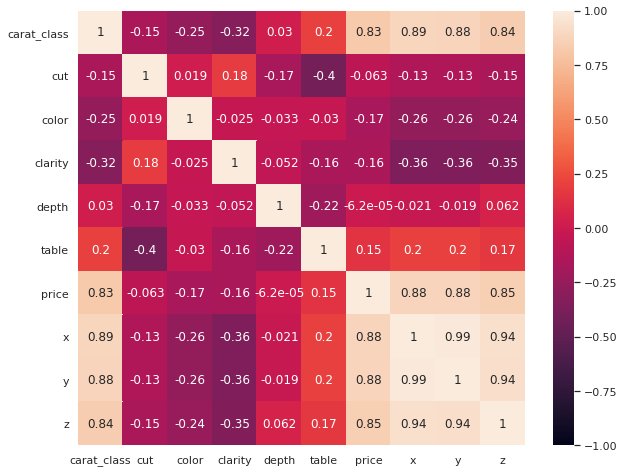

In [7]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [8]:
def categorize_x(x):
    to_return = None
    if x < 7:
        to_return = "low"
    elif x < 9:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

def categorize_y(y):
    to_return = None
    if y < 6:
        to_return = "low"
    elif y < 8:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

In [9]:
from sklearn.base import BaseEstimator,TransformerMixin

class CustomTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        print('\n')
        
    def fit(self,X,y=None):
        #print('\n>>>>>>>fit() called.\n')
        return self
    
    def transform(self,X,y=None):
        #print('\n>>>>>>>transform() called.\n')
        X_ = X.copy()

        X_['x_cat'] = X_['x'].apply(lambda x : categorize_x(x)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        X_['y_cat'] = X_['y'].apply(lambda y : categorize_y(y)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        
        return X_
        

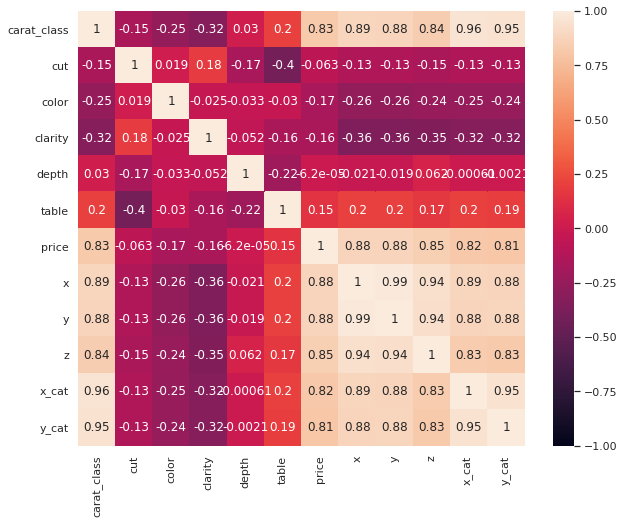

In [10]:
custom_transf = CustomTransformer()
new_train = custom_transf.transform(prep_train)

sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(new_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [11]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

In [11]:
f1_list = []
accuracy_list = []
precision_list = []
recall_list = []

n_feature = len(sample_train.columns)
for feature_dim in range(1,n_feature+3):
    #feature_dim = 4
    """
    Perform PCA in order to reduce the dataset dimensionality.
    """
    custom_transf = CustomTransformer()
    std_scale = StandardScaler()
    pca = PCA(n_components=feature_dim)
    clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)


    t0 = time.time()
    model = make_pipeline(custom_transf,std_scale,pca,clf)
    model.fit(sample_train, label_train)
    pred = model.predict(sample_val)

    t1 = time.time()

    f1 = f1_score(label_val,pred,average = 'macro')
    acc = accuracy_score(label_val,pred)
    precision = precision_score(label_val,pred,average = 'macro')
    recall = recall_score(label_val,pred,average = 'macro')
    print('PCA components: ',feature_dim)
    print('Time: ', t1-t0)
    
    f1_list.append(f1)
    accuracy_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    
    print(classification_report(label_val,pred))
    print('\n')

>>>>>>>init() called.
PCA components:  1
Time:  11.833287239074707
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.90      0.93       564

    accuracy                           0.99     12951
   macro avg       0.98      0.96      0.97     12951
weighted avg       0.99      0.99      0.99     12951



>>>>>>>init() called.
PCA components:  2
Time:  4.257983446121216
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.89      0.93       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.97     12951
weighted avg       0.98      0.98      0.98     12951



>>>>>>>init() called.
PCA components:  3
Time:  3.5863475799560547
              precision    recall 

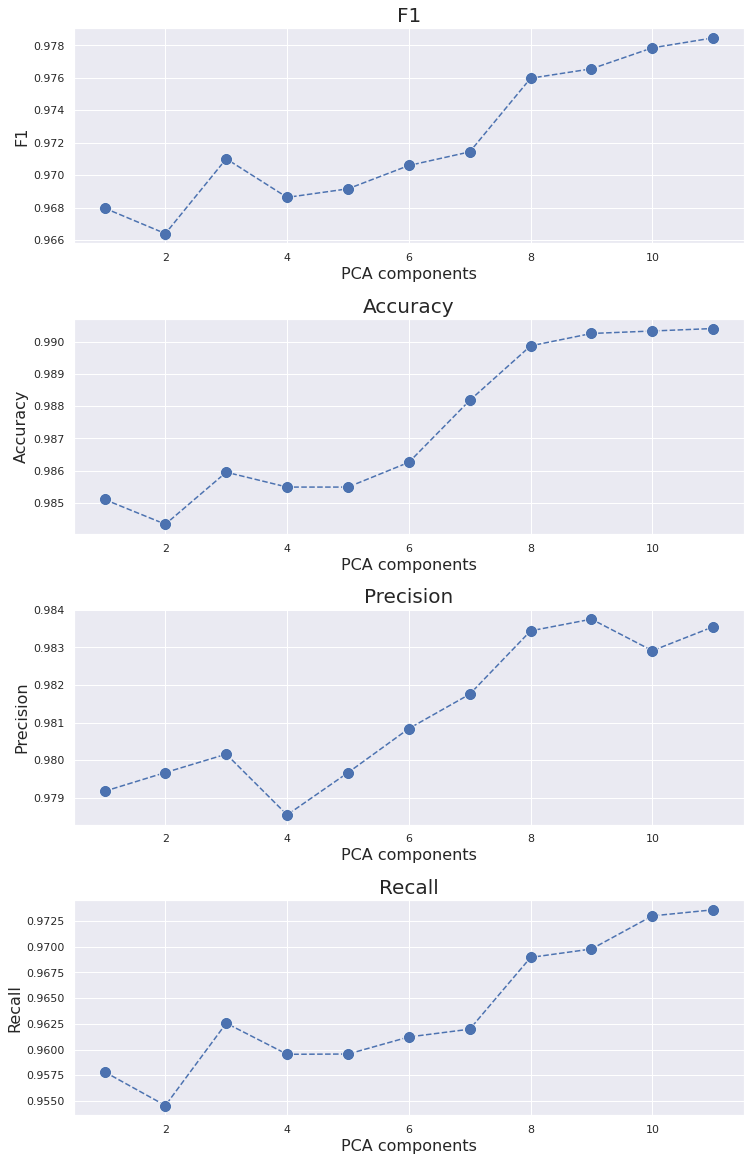

In [12]:
sns.set(rc={'figure.figsize':(12,20)})
sns.set_context("notebook", rc={"font.size":32,"axes.titlesize":20,"axes.labelsize":16})
fig, ax = plt.subplots(4,1)

for i,feature,result_list in zip(range(4),['F1','Accuracy','Precision','Recall'],
                                 [f1_list, accuracy_list,precision_list,recall_list]):
    sns.lineplot(x = range(1,12), y = result_list,
                 marker='o',markersize=12,linestyle='dashed', ax = ax[i])
    ax[i].set(ylabel=feature, xlabel='PCA components', title=feature)
    
plt.subplots_adjust(hspace = 0.35)
#plt.savefig("images/SparkLearningCurve.png")  
plt.show()

In [16]:
classifiers = [LogisticRegression(random_state = seed), GaussianNB(), 
               DecisionTreeClassifier(random_state = seed),
               SGDClassifier(random_state = seed), KNeighborsClassifier(), 
               SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed),
               SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
              ]

clf_names = ['Logistic Regression', 'Naive Bayes', 'Decision tree', 'SGD', 'KNN Classifier',
             'SVM linear', 'SVM rdf']

sampling_techs = [EditedNearestNeighbours(), RandomOverSampler(), SMOTE(random_state=seed)]
sampling_names = ['ENN-Undersample', 'ROS-Oversample','SMOTE']

In [51]:
best_f1

0.9754055908664537

In [52]:
best_clf

'SVM linear'

In [53]:
best_samp

'ENN-Undersample'



Classifier:  Logistic Regression
Sampling method:  ENN-Undersample
Time required:  1.9256961345672607
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



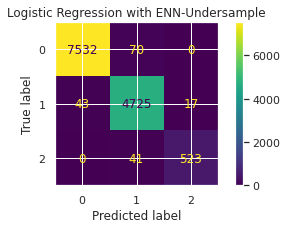



Classifier:  Logistic Regression
Sampling method:  ROS-Oversample
Time required:  1.9063279628753662
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.97      0.98      4785
           2       0.84      0.97      0.90       564

    accuracy                           0.98     12951
   macro avg       0.94      0.98      0.96     12951
weighted avg       0.99      0.98      0.98     12951



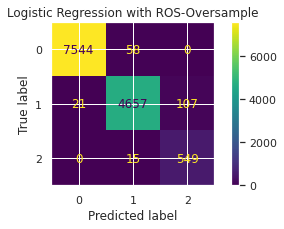



Classifier:  Logistic Regression
Sampling method:  SMOTE
Time required:  2.5142135620117188
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.99      0.98      0.98      4785
           2       0.85      0.97      0.91       564

    accuracy                           0.99     12951
   macro avg       0.94      0.98      0.96     12951
weighted avg       0.99      0.99      0.99     12951



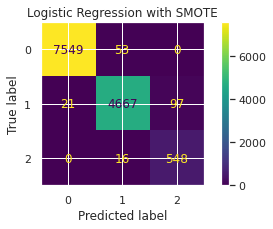



Classifier:  Naive Bayes
Sampling method:  ENN-Undersample
Time required:  0.9201719760894775
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.89      0.93       564

    accuracy                           0.98     12951
   macro avg       0.98      0.96      0.97     12951
weighted avg       0.98      0.98      0.98     12951



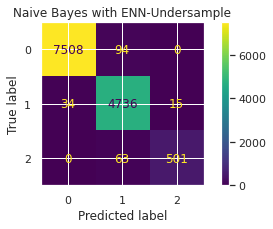



Classifier:  Naive Bayes
Sampling method:  ROS-Oversample
Time required:  0.12320661544799805
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.97      0.98      0.98      4785
           2       0.89      0.95      0.92       564

    accuracy                           0.98     12951
   macro avg       0.95      0.97      0.96     12951
weighted avg       0.98      0.98      0.98     12951



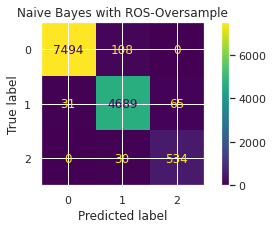



Classifier:  Naive Bayes
Sampling method:  SMOTE
Time required:  0.4862794876098633
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.97      0.98      0.98      4785
           2       0.89      0.94      0.92       564

    accuracy                           0.98     12951
   macro avg       0.95      0.97      0.96     12951
weighted avg       0.98      0.98      0.98     12951



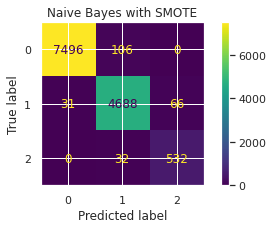



Classifier:  Decision tree
Sampling method:  ENN-Undersample
Time required:  1.1670937538146973
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.94      0.96      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



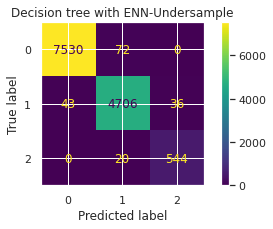



Classifier:  Decision tree
Sampling method:  ROS-Oversample
Time required:  0.5856707096099854
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.95      0.93      0.94       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



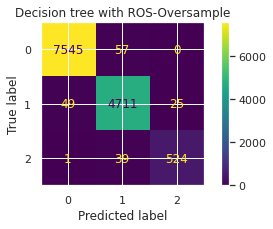



Classifier:  Decision tree
Sampling method:  SMOTE
Time required:  1.2375519275665283
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.90      0.95      0.92       564

    accuracy                           0.98     12951
   macro avg       0.96      0.97      0.96     12951
weighted avg       0.99      0.98      0.98     12951



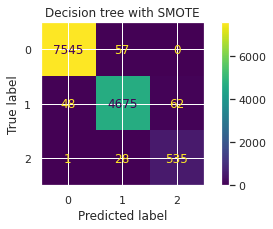



Classifier:  SGD
Sampling method:  ENN-Undersample
Time required:  1.003692626953125
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.94      0.96      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



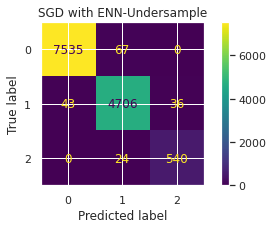



Classifier:  SGD
Sampling method:  ROS-Oversample
Time required:  0.48987412452697754
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7602
           1       0.99      0.96      0.98      4785
           2       0.80      0.97      0.88       564

    accuracy                           0.98     12951
   macro avg       0.93      0.98      0.95     12951
weighted avg       0.98      0.98      0.98     12951



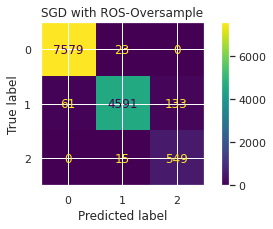



Classifier:  SGD
Sampling method:  SMOTE
Time required:  0.8370776176452637
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7602
           1       0.99      0.96      0.98      4785
           2       0.83      0.97      0.89       564

    accuracy                           0.98     12951
   macro avg       0.94      0.98      0.96     12951
weighted avg       0.99      0.98      0.98     12951



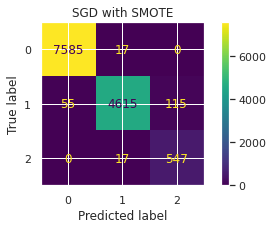



Classifier:  KNN Classifier
Sampling method:  ENN-Undersample
Time required:  1.7549138069152832
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.88      0.92       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.96     12951
weighted avg       0.98      0.98      0.98     12951



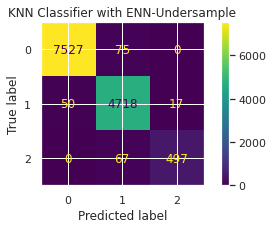



Classifier:  KNN Classifier
Sampling method:  ROS-Oversample
Time required:  1.0057225227355957
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.98      0.98      4785
           2       0.90      0.93      0.92       564

    accuracy                           0.98     12951
   macro avg       0.96      0.96      0.96     12951
weighted avg       0.98      0.98      0.98     12951



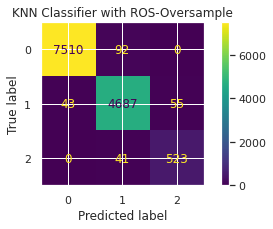



Classifier:  KNN Classifier
Sampling method:  SMOTE
Time required:  1.3795552253723145
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.98      0.97      4785
           2       0.88      0.94      0.91       564

    accuracy                           0.98     12951
   macro avg       0.95      0.97      0.96     12951
weighted avg       0.98      0.98      0.98     12951



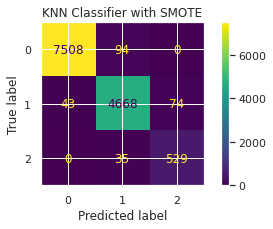



Classifier:  SVM linear
Sampling method:  ENN-Undersample
Time required:  1.3719813823699951
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



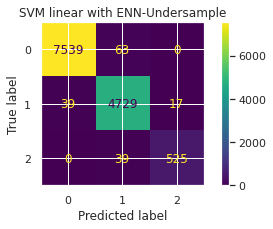



Classifier:  SVM linear
Sampling method:  ROS-Oversample
Time required:  10.01548171043396
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.86      0.97      0.91       564

    accuracy                           0.99     12951
   macro avg       0.95      0.98      0.96     12951
weighted avg       0.99      0.99      0.99     12951



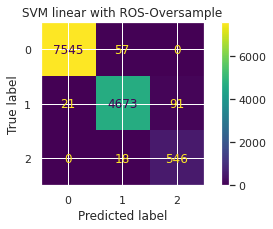



Classifier:  SVM linear
Sampling method:  SMOTE
Time required:  7.969819784164429
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.99      0.98      0.98      4785
           2       0.88      0.96      0.92       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



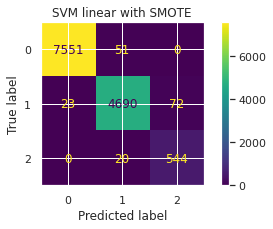



Classifier:  SVM rdf
Sampling method:  ENN-Undersample
Time required:  2.703187942504883
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



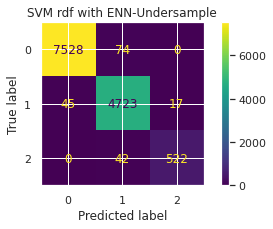



Classifier:  SVM rdf
Sampling method:  ROS-Oversample
Time required:  12.289290189743042
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.98      0.98      4785
           2       0.90      0.98      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



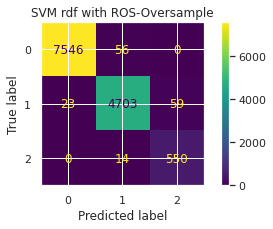



Classifier:  SVM rdf
Sampling method:  SMOTE
Time required:  11.470962762832642
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.91      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



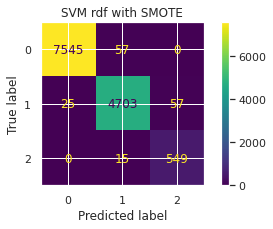

In [49]:
best_f1 = 0
best_clf = ''
best_samp = ''
for clf, clf_name in zip(classifiers,clf_names):
    for samp, samp_name in zip(sampling_techs,sampling_names):
        custom_transf = CustomTransformer()
        std_scale = StandardScaler()
        pca = PCA(n_components=8)
        
        t0 = time.time()
        model = make_pipeline(custom_transf,std_scale,pca,samp,clf)
        model.fit(sample_train, label_train)
        pred = model.predict(sample_val)
        t1 = time.time()
        f1 = f1_score(label_val,pred,average = 'macro')
        if f1 > best_f1:
            best_f1 = f1
            best_clf = clf_name
            best_samp = samp_name
        print('Classifier: ',clf_name)
        print('Sampling method: ',samp_name)
        print('Time required: ',t1-t0)
        print(classification_report(label_val,pred))
        img = sns.set(rc={'figure.figsize':(6,3)})
        plot_confusion_matrix(model, sample_val, label_val) 
        plt.title(clf_name + ' with '+samp_name)
        plt.show()

In [50]:
print(best_f1, best_clf, best_samp)

0.9754055908664537 SVM linear ENN-Undersample




Time required:  2221.1877636909485
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



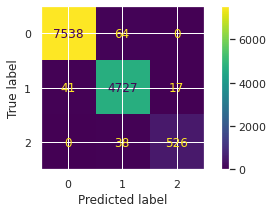

In [13]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline

custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)

pipeline = Pipeline([
    ('samp', EditedNearestNeighbours()),
    ('clf', SVC( random_state = seed)),
])

parameters = [
    {
        'samp__n_neighbors' : (3,10,100),
        'clf__kernel': ['linear','rbf'],
        'clf__C': [0.01,0.1,1,10,100]
    }
]

t0 = time.time()
grid_search = GridSearchCV(pipeline, parameters)

model = make_pipeline(custom_transf,std_scale, pca, grid_search)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
t1 = time.time()
print('Time required: ',t1-t0)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()

In [ ]:
model.best_params_